# Merge & Combine multiple cycles of Ib approximations

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import ICESat2GroundingLineMigration.IceSatHDF5Unpacker as unpack
import src.TrackProfileUtil as util
import src.SlopeBreak as slpbr
from matplotlib.animation import FuncAnimation 

/tmp/ipykernel_487/1547111078.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
study_area, lim = slpbr.studyArea("Bounds/bungen.gpkg")
xlim, ylim = lim

basemap = unpack.Basemap("BackgroundData/GroundedIce.gpkg")
gline_xy = util.gline_to_df(basemap.basemap_gpd, study_area)

In [3]:
paths = [f"Line/{i}-Ib.csv" for i in range(1, 12)]
print(paths)

['Line/1-Ib.csv', 'Line/2-Ib.csv', 'Line/3-Ib.csv', 'Line/4-Ib.csv', 'Line/5-Ib.csv', 'Line/6-Ib.csv', 'Line/7-Ib.csv', 'Line/8-Ib.csv', 'Line/9-Ib.csv', 'Line/10-Ib.csv', 'Line/11-Ib.csv']


In [4]:
parts = [pd.read_csv(path) for path in paths]
data = pd.concat(parts, ignore_index=True)

In [5]:
data.keys()

Index(['Unnamed: 0', 'x', 'y', 'time', 'cyc', 'track', 'qs', 'px1', 'py1',
       'px2', 'py2', 'geometry', 'min_dist'],
      dtype='object')

In [7]:
moa_gline = gpd.read_file("Line/moa_2009_groundingline_v02.0.shp")

## Visualize data alone

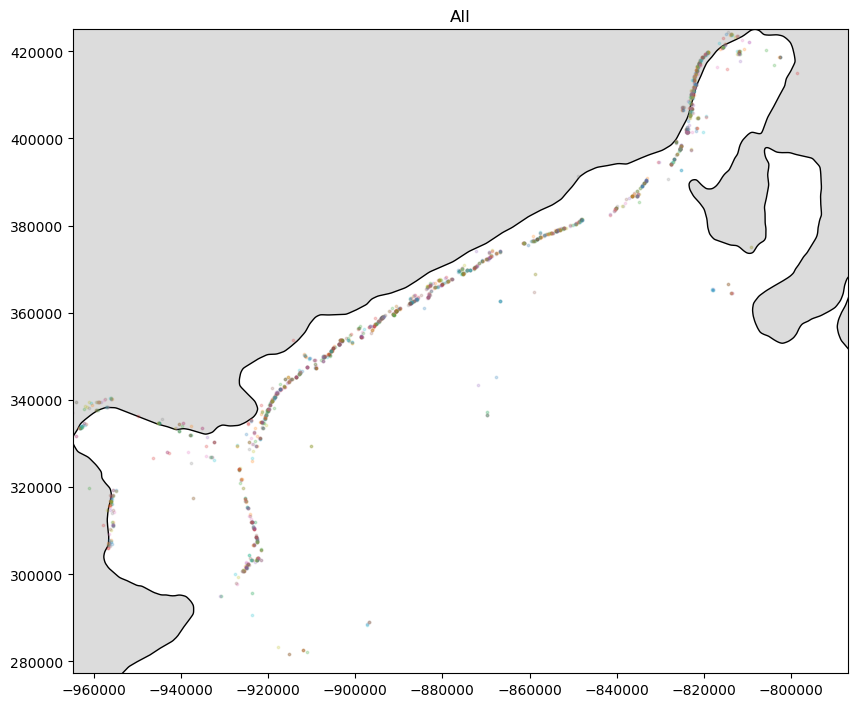

In [8]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
range_cnt = 20

ax.set_facecolor("gainsboro")
basemap.basemap_gpd.plot(ax=ax, color="white", edgecolor="black")

for i, dat in data.iterrows():
    plt.scatter(dat["x"], dat["y"], s = 3, alpha = 0.2)
    
ax.set_title("All")
ax.set_aspect('equal', adjustable='box')

plt.xlim(gline_xy["x"].min(), gline_xy["x"].max())
plt.ylim(gline_xy["y"].min(), gline_xy["y"].max())
    
plt.show()

## Visualize quality score parameter

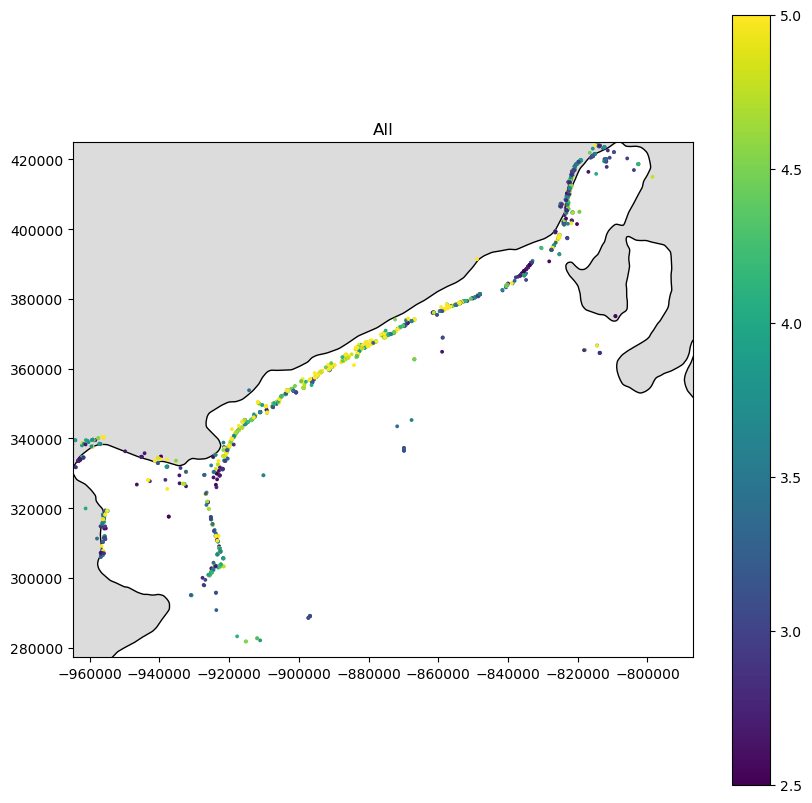

In [9]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
range_cnt = 20

ax.set_facecolor("gainsboro")
basemap.basemap_gpd.plot(ax=ax, color="white", edgecolor="black")

cs = plt.scatter(data["x"], data["y"], s = 3, c=data["qs"], vmin=2.5, vmax = 5)
    
ax.set_title("All")
ax.set_aspect('equal', adjustable='box')

plt.xlim(gline_xy["x"].min(), gline_xy["x"].max())
plt.ylim(gline_xy["y"].min(), gline_xy["y"].max())

plt.colorbar(cs)
    
plt.show()

## Visualize along with MOA grounding line model

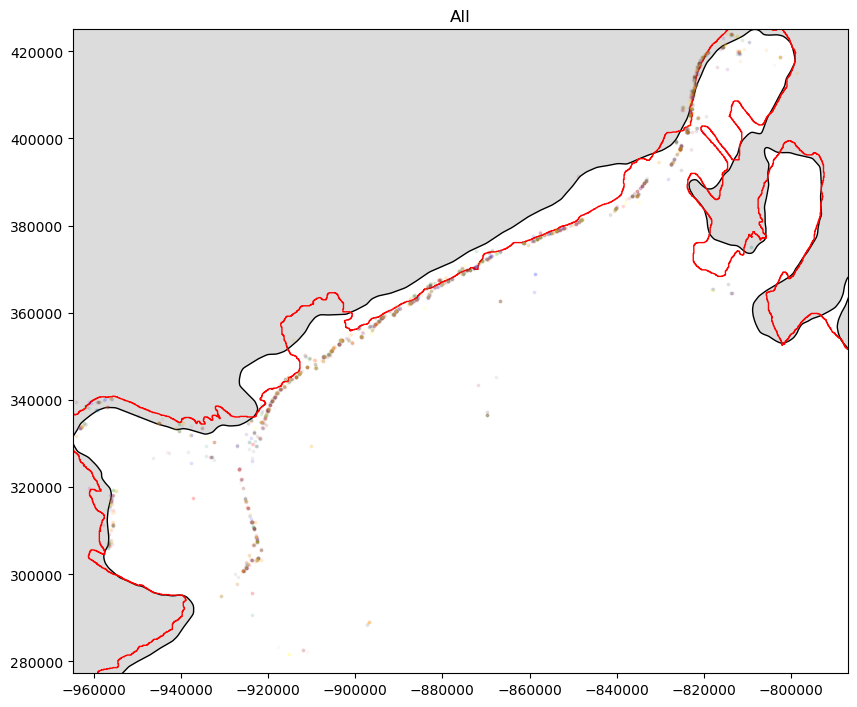

In [10]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
range_cnt = 20

ax.set_facecolor("gainsboro")
basemap.basemap_gpd.plot(ax=ax, color="white", edgecolor="black")

moa_gline.plot(ax=ax, color="none", edgecolor="red")

for i, dat in data.iterrows():
    plt.scatter(dat["x"], dat["y"], s = 3, c=colors[dat["cyc"]], alpha = 1/len(colors))
    
ax.set_title("All")
ax.set_aspect('equal', adjustable='box')

plt.xlim(gline_xy["x"].min(), gline_xy["x"].max())
plt.ylim(gline_xy["y"].min(), gline_xy["y"].max())
    
plt.show()

## Compute median of every track

In [11]:
all_rgts = []

for index, row in data.iterrows():
    if row["track"] not in all_rgts:
        all_rgts.append(row["track"])
            
all_rgts = sorted(all_rgts)

In [12]:
x_dict = {track:data[data["track"] == track]["x"].iloc[:] for track in all_rgts}
y_dict = {track:data[data["track"] == track]["y"].iloc[:] for track in all_rgts}

In [13]:
x_dict_a, x_dict_m = x_dict, x_dict
y_dict_a, y_dict_m = y_dict, y_dict

In [14]:
for key in x_dict:
    x_dict_a[key] = sum(x_dict[key]) / len(x_dict[key])
    x_dict_m[key] = np.median(np.array(x_dict[key]))
for key in y_dict:
    y_dict_a[key] = sum(y_dict[key]) / len(y_dict[key])
    y_dict_m[key] = np.median(np.array(y_dict[key]))

In [15]:
x_a, x_m = [x_dict_a[key] for key in x_dict.keys()], [x_dict_m[key] for key in x_dict.keys()]
y_a, y_m = [y_dict_a[key] for key in y_dict.keys()], [y_dict_m[key] for key in y_dict.keys()]

## Visualize track medians

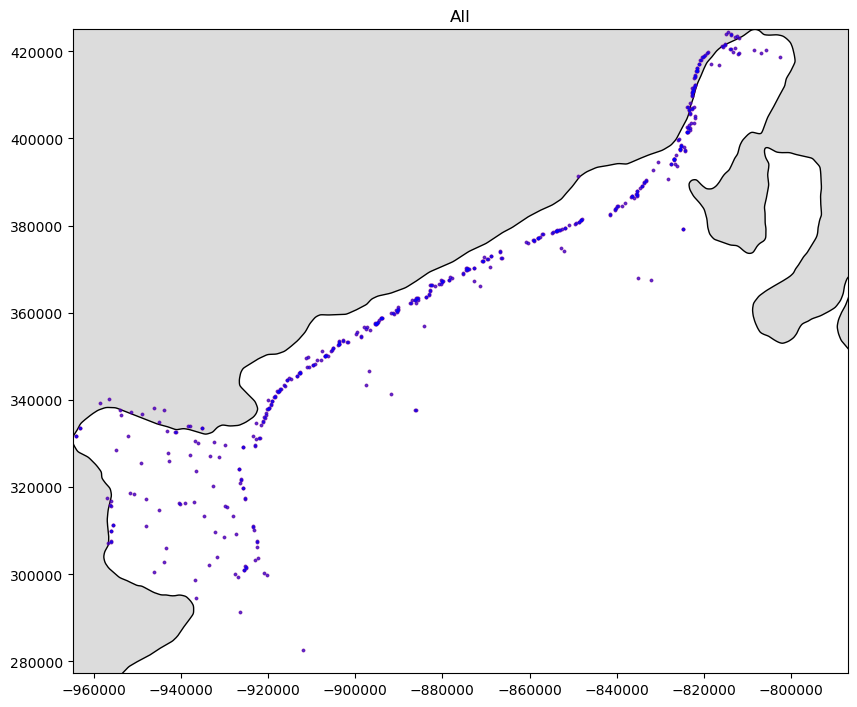

In [16]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
range_cnt = 20

ax.set_facecolor("gainsboro")
basemap.basemap_gpd.plot(ax=ax, color="white", edgecolor="black")
    
plt.scatter(x_a, y_a, s = 3, c="red", alpha = 0.5)
plt.scatter(x_m, y_m, s = 3, c="blue", alpha = 0.5)
    
ax.set_title("All")
ax.set_aspect('equal', adjustable='box')

plt.xlim(gline_xy["x"].min(), gline_xy["x"].max())
plt.ylim(gline_xy["y"].min(), gline_xy["y"].max())
    
plt.show()